In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install numpy

Looking in indexes: https://download.pytorch.org/whl/cu121


In [2]:
import os
import torch
import torchvision
import tarfile
from torchvision import datasets
from torch.utils.data import random_split
from torchvision.transforms import ToTensor

In [3]:
import torchvision.models as models

# Load a pre-trained ResNet-34
resnet34 = models.resnet34(pretrained=True)

# Load an untrained ResNet-34
resnet34_untrained = models.resnet34(pretrained=False)

print(resnet34)


c:\Users\bance\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\bance\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

c:\Users\bance\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [4]:
def count_hidden_layers(resnet_model):
    total_conv_layers = 1  # for the initial conv1 layer
    for name, module in resnet_model.named_children():
        if 'layer' in name:
            for block in module:
                total_conv_layers += len([l for l in block.children() if isinstance(l, torch.nn.Conv2d)])
    # Adding the fully connected layer
    total_hidden_layers = total_conv_layers + 1  # +1 for the fully connected layer
    return total_hidden_layers

print("Total hidden layers in ResNet-34:", count_hidden_layers(resnet34))


Total hidden layers in ResNet-34: 34


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import roc_auc_score
import numpy as np

class CNNWith5HiddenLayers(nn.Module):
    def __init__(self):
        super(CNNWith5HiddenLayers, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)     # Hidden layer 1
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)    # Hidden layer 2
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)   # Hidden layer 3
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)  # Hidden layer 4
        self.pool = nn.MaxPool2d(2, 2)                  # Auxiliary layer (Pooling)
        self.fc1 = nn.Linear(256 * 2 * 2, 512)          # Hidden layer 5 (Fully connected)
        self.fc2 = nn.Linear(512, 10)                   # Output layer
        self.relu = nn.ReLU()                           # Activation function
        self.dropout = nn.Dropout(0.5)                  # Auxiliary layer (Dropout)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        print(f"Shape before flattening: {x.shape}")  # Debugging line to check the shape
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Instantiate the model
model = CNNWith5HiddenLayers()

# Data augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, trainloader, criterion, optimizer, epochs=25):
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            if i % 100 == 99:  # Print every 100 batches
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{i+1}/{len(trainloader)}], Loss: {loss.item():.4f}")
        
        print(f"Epoch [{epoch+1}/{epochs}], Average Loss: {running_loss/len(trainloader):.4f}")

# Train the model
train_model(model, trainloader, criterion, optimizer, epochs=25)

def evaluate_model(model, testloader):
    model.eval()
    all_labels = []
    all_outputs = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader):
            outputs = model(inputs)
            all_labels.extend(labels.numpy())
            all_outputs.extend(torch.nn.functional.softmax(outputs, dim=1).numpy())
    
    all_labels = np.array(all_labels)
    all_outputs = np.array(all_outputs)
    
    # Compute AUC for each class and average them
    auc_scores = []
    for i in range(10):  # Assuming 10 classes for CIFAR-10
        auc = roc_auc_score(all_labels == i, all_outputs[:, i])
        auc_scores.append(auc)
    
    mean_auc = np.mean(auc_scores)
    print(f"AUC scores for each class: {auc_scores}")
    return mean_auc

# Evaluate the model
auc = evaluate_model(model, testloader)
print(f"Mean AUC: {auc}")


Files already downloaded and verified
Files already downloaded and verified
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape 

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import roc_auc_score
import numpy as np

class CNNWith5HiddenLayers(nn.Module):
    def __init__(self):
        super(CNNWith5HiddenLayers, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)     # Hidden layer 1
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)    # Hidden layer 2
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)   # Hidden layer 3
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)  # Hidden layer 4
        self.pool = nn.MaxPool2d(2, 2)                  # Auxiliary layer (Pooling)
        self.fc1 = nn.Linear(256 * 2 * 2, 512)          # Hidden layer 5 (Fully connected)
        self.fc2 = nn.Linear(512, 10)                   # Output layer
        self.relu = nn.ReLU()                           # Activation function
        self.dropout = nn.Dropout(0.5)                  # Auxiliary layer (Dropout)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        print(f"Shape before flattening: {x.shape}")  # Debugging line to check the shape
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Instantiate the model and move it to the device
model = CNNWith5HiddenLayers().to(device)

# Data augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, trainloader, criterion, optimizer, device, epochs=25):
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if i % 100 == 99:  # Print every 100 batches
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{i+1}/{len(trainloader)}], Loss: {loss.item():.4f}")
        
        accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{epochs}], Average Loss: {running_loss/len(trainloader):.4f}, Accuracy: {accuracy:.2f}%")

# Train the model
train_model(model, trainloader, criterion, optimizer, device, epochs=25)

def evaluate_model(model, testloader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    all_labels = []
    all_outputs = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_outputs.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())
    
    all_labels = np.array(all_labels)
    all_outputs = np.array(all_outputs)
    
    # Compute AUC for each class and average them
    auc_scores = []
    for i in range(10):  # Assuming 10 classes for CIFAR-10
        auc = roc_auc_score(all_labels == i, all_outputs[:, i])
        auc_scores.append(auc)
    
    mean_auc = np.mean(auc_scores)
    accuracy = 100 * correct / total
    print(f"AUC scores for each class: {auc_scores}")
    print(f"Accuracy: {accuracy:.2f}%")
    return mean_auc

# Evaluate the model
auc = evaluate_model(model, testloader, device)
print(f"Mean AUC: {auc}")


Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100,

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import roc_auc_score
import numpy as np

class CNNWith5HiddenLayers(nn.Module):
    def __init__(self):
        super(CNNWith5HiddenLayers, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)     # Hidden layer 1
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)    # Hidden layer 2
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)   # Hidden layer 3
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)  # Hidden layer 4
        self.pool = nn.MaxPool2d(2, 2)                  # Auxiliary layer (Pooling)
        self.fc1 = nn.Linear(256 * 2 * 2, 512)          # Hidden layer 5 (Fully connected)
        self.fc2 = nn.Linear(512, 10)                   # Output layer
        self.relu = nn.ReLU()                           # Activation function
        self.dropout = nn.Dropout(0.5)                  # Auxiliary layer (Dropout)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        print(f"Shape before flattening: {x.shape}")  # Debugging line to check the shape
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Instantiate the model and move it to the device
model = CNNWith5HiddenLayers().to(device)

# Transform to convert images to tensors without normalization or augmentation
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, trainloader, criterion, optimizer, device, epochs=25):
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if i % 100 == 99:  # Print every 100 batches
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{i+1}/{len(trainloader)}], Loss: {loss.item():.4f}")
        
        accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{epochs}], Average Loss: {running_loss/len(trainloader):.4f}, Accuracy: {accuracy:.2f}%")

# Train the model
train_model(model, trainloader, criterion, optimizer, device, epochs=25)

def evaluate_model(model, testloader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    all_labels = []
    all_outputs = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_outputs.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())
    
    all_labels = np.array(all_labels)
    all_outputs = np.array(all_outputs)
    
    # Compute AUC for each class and average them
    auc_scores = []
    for i in range(10):  # Assuming 10 classes for CIFAR-10
        auc = roc_auc_score(all_labels == i, all_outputs[:, i])
        auc_scores.append(auc)
    
    mean_auc = np.mean(auc_scores)
    accuracy = 100 * correct / total
    print(f"AUC scores for each class: {auc_scores}")
    print(f"Accuracy: {accuracy:.2f}%")
    return mean_auc

# Evaluate the model
auc = evaluate_model(model, testloader, device)
print(f"Mean AUC: {auc}")


Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100, 256, 2, 2])
Shape before flattening: torch.Size([100,

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Epoch [1/25], Batch [100/500], Loss: 1.8614
Epoch [1/25], Batch [200/500], Loss: 1.5304
Epoch [1/25], Batch [300/500], Loss: 1.4275
Epoch [1/25], Batch [400/500], Loss: 1.3310
Epoch [1/25], Batch [500/500], Loss: 1.3585
Epoch [1/25], Average Loss: 1.6779, Accuracy: 37.72%
Epoch [2/25], Batch [100/500], Loss: 1.3492
Epoch [2/25], Batch [200/500], Loss: 1.1925
Epoch [2/25], Batch [300/500], Loss: 1.2442
Epoch [2/25], Batch [400/500], Loss: 1.1251
Epoch [2/25], Batch [500/500], Loss: 1.0498
Epoch [2/25], Average Loss: 1.2461, Accuracy: 55.12%
Epoch [3/25], Batch [100/500], Loss: 1.1341
Epoch [3/25], Batch [200/500], Loss: 0.9789
Epoch [3/25], Batch [300/500], Loss: 0.8217
Epoch [3/25], Batch [400/500], Loss: 0.8290
Epoch [3/25], Batch [500/500], Loss: 0.9193
Epoch [3/25], Average Loss: 1.0362, Accuracy: 63.16%
Epoch [4/25], Batch [100/500], Loss: 0.7386
Epoch [4/25], Batch [200/500], Loss: 0.861

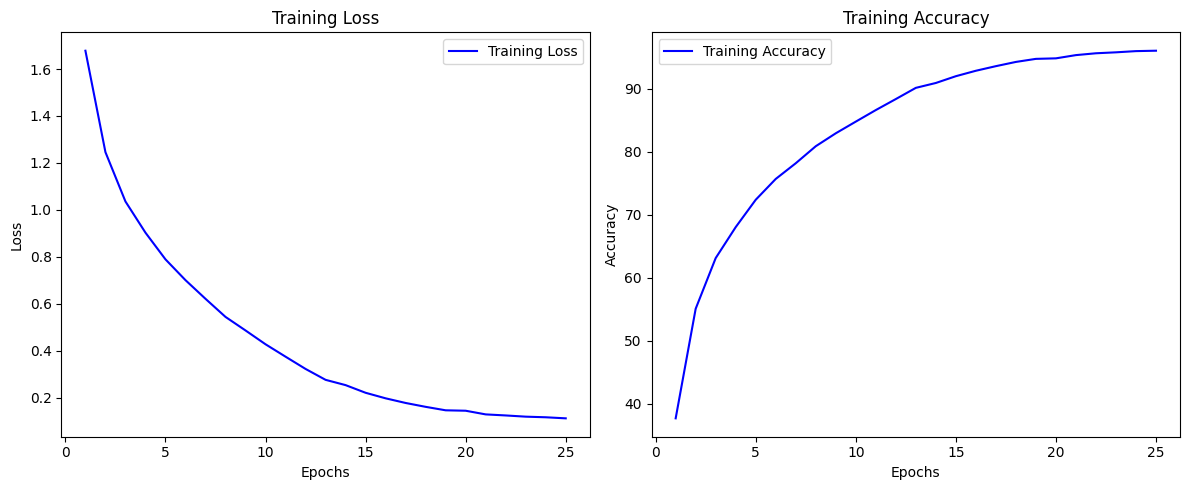

In [8]:
!pip install matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import numpy as np

class CNNWith5HiddenLayers(nn.Module):
    def __init__(self):
        super(CNNWith5HiddenLayers, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)     # Hidden layer 1
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)    # Hidden layer 2
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)   # Hidden layer 3
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)  # Hidden layer 4
        self.pool = nn.MaxPool2d(2, 2)                  # Auxiliary layer (Pooling)
        self.fc1 = nn.Linear(256 * 2 * 2, 512)          # Hidden layer 5 (Fully connected)
        self.fc2 = nn.Linear(512, 10)                   # Output layer
        self.relu = nn.ReLU()                           # Activation function
        self.dropout = nn.Dropout(0.5)                  # Auxiliary layer (Dropout)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Instantiate the model and move it to the device
model = CNNWith5HiddenLayers().to(device)

# Transform to convert images to tensors without normalization or augmentation
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, trainloader, criterion, optimizer, device, epochs=25):
    train_loss = []
    train_accuracy = []
    
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if i % 100 == 99:  # Print every 100 batches
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{i+1}/{len(trainloader)}], Loss: {loss.item():.4f}")
        
        accuracy = 100 * correct / total
        train_loss.append(running_loss / len(trainloader))
        train_accuracy.append(accuracy)
        print(f"Epoch [{epoch+1}/{epochs}], Average Loss: {running_loss/len(trainloader):.4f}, Accuracy: {accuracy:.2f}%")
    
    return train_loss, train_accuracy

def evaluate_model(model, testloader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    all_labels = []
    all_outputs = []
    with torch.inference_mode():
        for i, (inputs, labels) in enumerate(testloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_outputs.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())
    
    all_labels = np.array(all_labels)
    all_outputs = np.array(all_outputs)
    
    # Compute AUC for each class and average them
    auc_scores = []
    for i in range(10):  # Assuming 10 classes for CIFAR-10
        auc = roc_auc_score(all_labels == i, all_outputs[:, i])
        auc_scores.append(auc)
    
    mean_auc = np.mean(auc_scores)
    accuracy = 100 * correct / total
    print(f"AUC scores for each class: {auc_scores}")
    print(f"Accuracy: {accuracy:.2f}%")
    return mean_auc

# Train the model and get training loss and accuracy
train_loss, train_accuracy = train_model(model, trainloader, criterion, optimizer, device, epochs=25)

# Evaluate the model
auc = evaluate_model(model, testloader, device)
print(f"Mean AUC: {auc}")

# Plot the training loss and accuracy
epochs = range(1, 26)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
